# Part 1: Snapshot structure and dealing with large simulations
In this first part, we will take a look at the basic file structure of simulation snapshots and demonstrate how to deal efficiently with very large simulations.

## Basic simulation file structures

In this notebook, we will be analyzing one of the FLAMINGO simulations, a recent suite of large hydrodynamical galaxy formation simulations. These simulations were run with the **SWIFT** code. Each simulation also has a basic "dark matter only" version that only simulates the gravitational N-body dynamics. We will begin with one such run, specifically the basic ``L1000N0900/DMO_FIDUCIAL`` simulation. As the name suggests, this is a simulation in a $(1000\,\rm{Mpc})^3$ volume with $900^3$ dark matter particles.

The most basic simulation output is a particle snapshot, containing the positions and velocities (and more generally all physical properties) of the particles at a given time. Like many modern codes, SWIFT outputs snapshots in the hierarchichal **hdf5** format.

To begin, copy a downsampled snapshot (meaning only a fraction of the particles have been stored) to your working directory.

*Note: Within Jupyter, you can run shell commands with the ! operator.*

In [31]:
!cp /snap8/scratch/do020/dc-elbe1/summer_school/FLAMINGO/L1000N0900/DMO_FIDUCIAL/snapshots_downsampled/flamingo_0077.hdf5 .

In [1]:
import h5py

# Manually open the hdf5 file with h5py
snapshot_name = "flamingo_0077.hdf5"
f = h5py.File(snapshot_name, mode="r")

# You can explore the file by looking at the keys
for key in f.keys():
    print(key)

Cells
Code
Cosmology
DMParticles
GravityScheme
Header
ICs_parameters
InternalCodeUnits
NeutrinoParticles
Parameters
PartType1
PartType6
PhysicalConstants
Policy
SubgridScheme
Units
UnusedParameters


In [2]:
# For a more interactive way to navigate, we can use h5glance

from h5glance import H5Glance
H5Glance(f)

flamingo_0077.hdf5/
├Cells	(5 children)
├Code	(0 children) (17 attributes)
├Cosmology	(0 children) (37 attributes)
├DMParticles	-> PartType1
├GravityScheme	(0 children) (22 attributes)
├Header	(1 children) (23 attributes)
├ICs_parameters	(0 children) (18 attributes)
├InternalCodeUnits	(0 children) (5 attributes)
├NeutrinoParticles	-> PartType6
├Parameters	(0 children) (200 attributes)
├PartType1	(3 children) (2 attributes)
├PartType6	(5 children) (2 attributes)
├PhysicalConstants	(2 children) (1 attributes)
├Policy	(0 children) (27 attributes)
├SubgridScheme	(1 children) (5 attributes)
├Units	(0 children) (5 attributes)
└UnusedParameters	(0 children) (151 attributes)

In [3]:
# Key simulation parameters are stored as attributes in the Header group
for key in f['Header'].attrs.keys():
    print(key)

print("")
print("This snapshot was taken at z = ", f['Header'].attrs['Redshift'])

BoxSize
Code
Dimension
Flag_Entropy_ICs
InitialMassTable
MassTable
NumFilesPerSnapshot
NumPartTypes
NumPart_ThisFile
NumPart_Total
NumPart_Total_HighWord
OutputType
Redshift
RunName
Scale-factor
SelectOutput
SnapshotDate
System
ThisFile
Time
TimeBase_dloga
TimeBase_dt
Virtual

This snapshot was taken at z =  [0.]


In [4]:
# We can take a first look at the dark matter particle data
pos = f["DMParticles/Coordinates"][:]

print(pos[:10])

# Close the hdf5 file
f.close()

[[  3.74712642   5.61080642  99.70342642]
 [  6.69870642   2.73484642  97.55512642]
 [  5.75061642   3.61796642 109.29767642]
 [  1.98590642  13.74927642 101.65533642]
 [  7.31384642  14.88142642 106.83866642]
 [  0.73240642   8.32923642 103.90451642]
 [ 13.97509642   4.60402642  96.78856642]
 [ 14.09954642   4.84256642  96.74939642]
 [ 12.32966642   3.85578642  95.15404642]
 [ 12.28059642   5.24723642  96.20385642]]


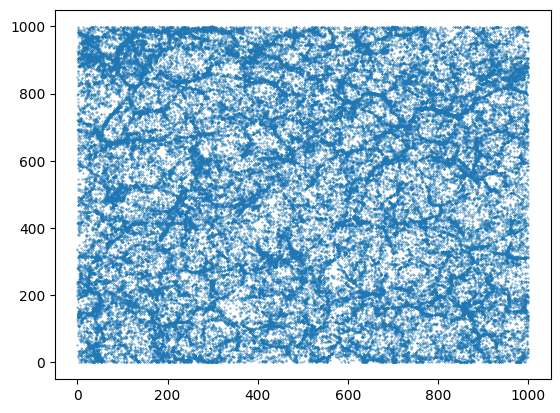

In [5]:
from matplotlib import pyplot as plt

# Make a scatter plot of particles in the slice 900 Mpc < z < 915 Mpc
select = (pos[:,2] > 900) & (pos[:,2] < 915)

plt.scatter(pos[select,0], pos[select,1], s=0.1)

## Dealing with large simulations

When we are dealing with large simulations, it is often not necessary to process entire snapshots. SWIFT stores particle data in a localized manner, allowing us to select only a region of interest. This is done using rectangular ``Cell`` structures. Let's try this out on the same simulation, but this time using a full particle snapshot rather than a downsampled one.

In [35]:
# Open the hdf5 file with h5py
snapshot_name = "/snap8/scratch/do020/dc-elbe1/summer_school/FLAMINGO/L1000N0900/DMO_FIDUCIAL/snapshots/flamingo_0077/flamingo_0077.hdf5"
f = h5py.File(snapshot_name, mode="r")

# Explore the structure of the Cells group
H5Glance(f["Cells"])


/snap8/scratch/do020/dc-elbe1/summer_school/FLAMINGO/L1000N0900/DMO_FIDUCIAL/snapshots/flamingo_0077/flamingo_0077.hdf5/Cells
├Centres	[float64: 32768 × 3]
├Counts	(2 children)
├Files	(2 children)
├Meta-data	(0 children) (3 attributes)
└OffsetsInFile	(2 children)

The Cells structure contains a ``Centres`` dataset that specifies the coordinates of each Cell, as well as the Counts and Indices of the corresponding particles. Let's load all the particles in some cell.

In [36]:
# The cell number of interest
cell_num = 24472

cell_centre = f["Cells/Centres"][cell_num]
cell_size = f["Cells/Meta-data"].attrs['size']
cell_corner = cell_centre - cell_size/2

print("Cell", cell_num)
print("Min:", cell_corner)
print("Max:", cell_corner+cell_size)

# Load the DM particles in this cell
count = f["Cells/Counts/PartType1"][cell_num]
offset = f["Cells/OffsetsInFile/PartType1"][cell_num]

pos = f["PartType1/Coordinates"][offset:offset+count]
masses = f["PartType1/Masses"][offset:offset+count] * 10 ** 10

print("\nActual particle positions:")
print("Min:", pos.min(axis=0))
print("Max:", pos.max(axis=0))

# Close the file
f.close()

Cell 24472
Min: [718.75000035 875.00000042 750.00000036]
Max: [750.00000036 906.25000044 781.25000038]

Actual particle positions:
Min: [718.75050041 875.00349041 750.00112041]
Max: [749.99862041 906.24647041 781.24862041]


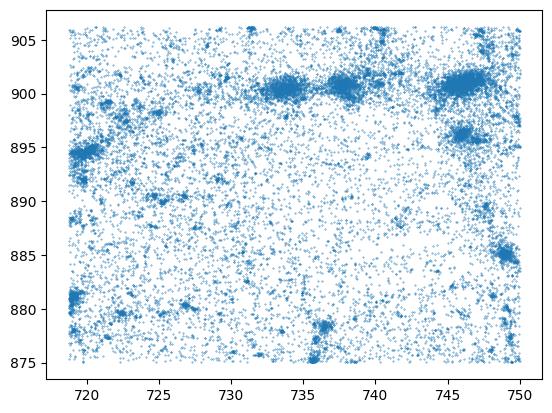

In [8]:
from matplotlib import pyplot as plt

# Make a scatter plot of particles in the cell
plt.scatter(pos[:,0], pos[:,1], s=0.1, c="C0")

## Dark matter halos

One of the oldest algorithms used to identify bound structures is the *friends of friends (FOF)* algorithm, which links all particles that are within a given linking length $\ell$. If you want to get a better understanding of this algorithm, take a look at Will Roper's SWIFT tutorials: https://github.com/WillJRoper/SWIFT-Workshop/blob/main/notebooks/The_EAGLE_Model.ipynb

As you might expect, the friends of friends algorithm is not perfect. For example, it tends to link structures through tenuous particle bridges. Nevertheless, many modern halo finders begin with an initial FOF step, after which actual bound structures are identified through some unbinding procedure. A particular challenge is identifying subhalos. This is often accomplished by not just using spatial information, by also incorporating phase space or evolutionary information.

We can take a look at a proper halo catalogue for this FLAMINGO simulation. This catalogue was generated with the ``HBT+`` algorithm, which uses the evolutionary tracks of halos to identify precisely when halos become subhalos. The catalgoue was then further processed with the ``SOAP`` code to compute a great number of halo properties (masses, velocity dispersions, shape parameters etc.) within spherical apertures.

In [32]:
# Load the SOAP catalogue
catname = "/snap8/scratch/do020/dc-elbe1/summer_school/FLAMINGO/L1000N0900/DMO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
f = h5py.File(catname, mode="r")

# Load spherical overdensity masses
M200 = f["SO/200_crit/TotalMass"][:] * 1e10
f.close()

# Print some halo masses
print(M200[:10])

[1.646e+13 1.009e+13 4.625e+12 7.370e+12 0.000e+00 4.200e+12 6.240e+12
 7.390e+12 1.376e+13 3.315e+12]


## Excercise 1
Plot the **halo mass function** for this small cell of the simulation.

## Beyond Cells: Loading individual halos

When dealing with large simulations, we can go beyond loading all the particles in a cell. What if we are only interested in dealing with one specific halo? The ``swiftsimio`` and ``swiftgalaxy`` packages provide this capability.

In [33]:
from swiftgalaxy import SWIFTGalaxy, SWIFTGalaxies, MaskCollection, SOAP
import unyt as u

# The index of the halo of interest
halo_id = 206947

# A virtual particle snapshot that also contains the halo ID of each particle
virtual_snapshot = "/snap8/scratch/do020/dc-elbe1/summer_school/FLAMINGO/L1000N0900/DMO_FIDUCIAL/snapshots/flamingo_0077/flamingo_soap_0077.hdf5"

# Open the virtual snapshot and halo catalogue
sg = SWIFTGalaxy(
    virtual_snapshot,
    SOAP(
        catname,
        soap_index=halo_id
    )
)

# Create a particle mask that only loads the particles from this specific halo
# Only select particles within a 1 Mpc aperture
mask_collection = MaskCollection(
    dark_matter=sg.dark_matter.spherical_coordinates.r.value < 1 * u.Mpc
)
sg.mask_particles(mask_collection)

# Load the coordinates of the DM particles in this halo
pos = sg.dark_matter.coordinates

/cosma/home/durham/dc-elbe1/venvs/my_environment/lib/python3.12/site-packages/swiftsimio/masks.py:266: UserWarning: Snapshot does not contain Cells/MinPositions and Cells/MaxPositions metadata. Padding region by 0.1 times cell length to account for drifted particles. This behaviour can be configured/disabled with the `safe_padding` parameter when creating the mask. See https://swiftsimio.readthedocs.io/en/latest/masking/index.html for further details.
  warnings.warn(


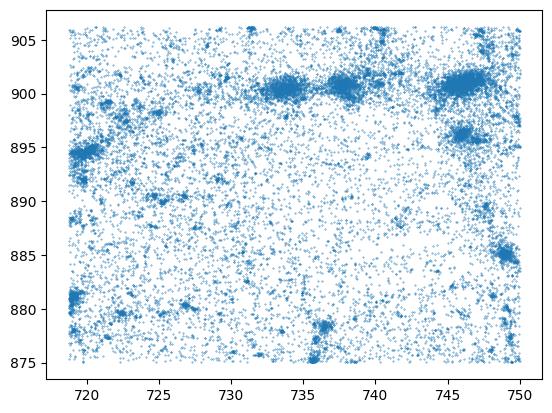

In [37]:
from matplotlib import pyplot as plt

# Plot all particles in this 1 Mpc aperture
plt.scatter(pos[:,0], pos[:,1], s=0.1, c="C0")


## Excercise 2
Based on a 0.1% sampling of halos, compute the average radial mass profile for halos with $10^{14}\,\mathrm{M}_\odot<M < 10^{15}\,\mathrm{M}_\odot$.

*Hint: You can efficiently process multiple halos by using SWIFTGalaxies with the syntax given below. However, do no try to load too many halos!*

In [ ]:
from swiftgalaxy import SWIFTGalaxies

# Open the virtual snapshot and halo catalogue
sgs = SWIFTGalaxies(
    virtual_snapshot,
    SOAP(
        catname,
        soap_index=[..., ..., ...]
        
    ),
    # Preloading datasets minimizes I/O operations
    preload={
        "dark_matter.masses",
        "dark_matter.coordinates",
   }
)

## Takeaways
* The hierarchical ``hdf5`` format is more user friendly and efficient than traditional binary formats
* When dealing with large simulations, it is often not necessary to load all particle data
* Codes like ``swiftgalaxy``, ``SOAP``, and ``tangos`` can be used to efficiently process multiple halos